In [1]:
import numpy as np
import pandas as pd 
import re
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
# import nltk
# import spacy                                       ## pip install -U spacy
# from nltk.tokenize.toktok import ToktokTokenizer
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

In [2]:
from nltk.cluster import KMeansClusterer
import nltk
from sklearn.manifold import TSNE

In [3]:
from sklearn.cluster import KMeans

In [4]:
import numpy as np
import seaborn as sns

In [5]:
data = pd.read_csv('fbportal_new.csv')
data.head()

,Test Case Description,Label
0,What's the weather like in Chicago?,Weather
1,What is the forecast in Tampa for tomorrow?,Weather
2,What is the weather in Oregon today?,Weather
3,Is it raining in France right now?,Weather
4,Show me the weather in Mexico for next week.,Weather


In [6]:
def text_cleaner(text):
   
    newString = text.lower()
    newString = re.sub(r"pre-conditions:","",newString)
    newString = re.sub(r"precondition:","",newString)
    newString = re.sub(r"hey","",newString)
    newString = re.sub(r"portal","",newString)
    newString = re.sub(r"hp","",newString)
    newString = re.sub(r"[^a-zA-Z]+", ' ', newString)
    #newString = remove_stopwords(newString)
    return newString
    

In [7]:
#call the function
cleaned_text = []
data['Test Case Description']=data['Test Case Description'].astype(str)
for t in data['Test Case Description']:
    cleaned_text.append(text_cleaner(t))
data['cleaned_text']=cleaned_text

In [8]:
print('The number of duplicate records are: ',data.duplicated().sum())
# Extract duplicate rows
data.loc[data.duplicated(), :]
### Dropping duplicates
data.drop_duplicates(keep='first', inplace=True)
data.shape

The number of duplicate records are:  87


(740, 3)

In [9]:
## Merging the domain of Assistant_messenger + Device + Wolfarm_food + Screen_Reader = Device and Calling + Meta = Calling
# replacement_mapping_dict = {
#     "The Fellowship Of The Ring": "The Fellowship of the Ring",
#     "The Return Of The King": "The Return of the King"
# }
data['Label'].replace(to_replace =["Assistant_messenger", "Wolfarm_food",'Screen_Reader'], 
                            value ="Device", inplace=True)
data['Label'].replace(to_replace =["Meta"], value ="Calling", inplace=True)




## Sentence Embedding and applying clustering on it by using sentence_transformers

#### Trying with all-mpnet-base-v2 pre-trained model

In [9]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-mpnet-base-v2')

In [10]:
def embeddings(data):
    sentence_embeddings = model.encode(list(data['cleaned_text']))
    return sentence_embeddings
embeddings_trs=embeddings(data)
data['embediing_trf_mpnet']=list(embeddings_trs)

In [11]:
data['embediing_trf_mpnet'][0].shape

(768,)

In [12]:
data.head()

,Test Case Description,Label,cleaned_text,embediing_trf_mpnet
0,What's the weather like in Chicago?,Weather,what s the weather like in chicago,"[-0.038886096, 0.039172754, -0.011775193, -0.012595732, 0.008800774, 0.01456551, -0.018293185, 0.029476797, 0.08851275, -0.008131694, -0.07434538, 0.051997386, 0.028299224, 0.008803181, -0.0287639..."
1,What is the forecast in Tampa for tomorrow?,Weather,what is the forecast in tampa for tomorrow,"[-0.021300891, -0.034242995, -0.039931852, -0.007983509, 0.01460343, -0.009178294, -0.013319595, -0.033735033, -0.0997696, 0.032089926, -0.042296473, -0.03623118, -0.005259653, 0.06721202, 0.03618..."
2,What is the weather in Oregon today?,Weather,what is the weather in oregon today,"[-0.050034232, -0.00045952457, -0.003059001, -0.014385757, 0.0065113897, -0.038505636, -0.04483619, -0.0004178389, 0.05123474, 0.0062194103, -0.045502726, 0.013734401, -0.009135769, -0.018035553, ..."
3,Is it raining in France right now?,Weather,is it raining in france right now,"[-0.024892785, 0.033829536, 0.00089585804, 0.031008298, -0.026053838, -0.034015376, -0.02972944, -0.054713596, 0.004699974, -0.009077651, -0.023102218, -0.011936427, -0.026847985, -0.01125945, 0.0..."
4,Show me the weather in Mexico for next week.,Weather,show me the weather in mexico for next week,"[-0.083847985, 0.09669932, -0.03942845, 0.033640042, 0.0126712015, -0.017876077, -0.014058308, -0.0055490136, 0.07294762, 0.014877581, -0.0630999, 0.029793836, 0.009281708, 0.05432795, 0.03318317,..."


### Clustering by KMeansClusterer


In [13]:
len(data['Label'].value_counts())

17

In [22]:
def clustering_data_trf(data,NUM_CLUSTERS = 17):

    sentences = data['cleaned_text']

    X = np.array(data['embediing_trf_mpnet'].tolist())

    kclusterer = KMeansClusterer(
        NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance,
        repeats=25,avoid_empty_clusters=True)

    assigned_clusters = kclusterer.cluster(X, assign_clusters=True)

    data['cluster_trf_mpnet'] = pd.Series(assigned_clusters, index=data.index)
    data['centroid_trf_mpnet'] = data['cluster_trf_mpnet'].apply(lambda x: kclusterer.means()[x])
    return data, assigned_clusters

In [23]:
data, cluster_trf=clustering_data_trf(data)

In [24]:
data.head()

,Test Case Description,Label,cleaned_text,embediing_trf_mpnet,cluster_trf_mpnet,centroid_trf_mpnet
0,What's the weather like in Chicago?,Weather,what s the weather like in chicago,"[-0.038886096, 0.039172754, -0.011775193, -0.012595732, 0.008800774, 0.01456551, -0.018293185, 0.029476797, 0.08851275, -0.008131694, -0.07434538, 0.051997386, 0.028299224, 0.008803181, -0.0287639...",14,"[-0.04197938, -0.01460063, -0.014748496, 0.004982655, -0.00164114, -0.009692915, -0.029443955, -0.009231339, 0.031613506, 0.007857433, -0.032034595, 0.019200364, 0.0029213745, 0.020416975, 0.02309..."
1,What is the forecast in Tampa for tomorrow?,Weather,what is the forecast in tampa for tomorrow,"[-0.021300891, -0.034242995, -0.039931852, -0.007983509, 0.01460343, -0.009178294, -0.013319595, -0.033735033, -0.0997696, 0.032089926, -0.042296473, -0.03623118, -0.005259653, 0.06721202, 0.03618...",14,"[-0.04197938, -0.01460063, -0.014748496, 0.004982655, -0.00164114, -0.009692915, -0.029443955, -0.009231339, 0.031613506, 0.007857433, -0.032034595, 0.019200364, 0.0029213745, 0.020416975, 0.02309..."
2,What is the weather in Oregon today?,Weather,what is the weather in oregon today,"[-0.050034232, -0.00045952457, -0.003059001, -0.014385757, 0.0065113897, -0.038505636, -0.04483619, -0.0004178389, 0.05123474, 0.0062194103, -0.045502726, 0.013734401, -0.009135769, -0.018035553, ...",14,"[-0.04197938, -0.01460063, -0.014748496, 0.004982655, -0.00164114, -0.009692915, -0.029443955, -0.009231339, 0.031613506, 0.007857433, -0.032034595, 0.019200364, 0.0029213745, 0.020416975, 0.02309..."
3,Is it raining in France right now?,Weather,is it raining in france right now,"[-0.024892785, 0.033829536, 0.00089585804, 0.031008298, -0.026053838, -0.034015376, -0.02972944, -0.054713596, 0.004699974, -0.009077651, -0.023102218, -0.011936427, -0.026847985, -0.01125945, 0.0...",14,"[-0.04197938, -0.01460063, -0.014748496, 0.004982655, -0.00164114, -0.009692915, -0.029443955, -0.009231339, 0.031613506, 0.007857433, -0.032034595, 0.019200364, 0.0029213745, 0.020416975, 0.02309..."
4,Show me the weather in Mexico for next week.,Weather,show me the weather in mexico for next week,"[-0.083847985, 0.09669932, -0.03942845, 0.033640042, 0.0126712015, -0.017876077, -0.014058308, -0.0055490136, 0.07294762, 0.014877581, -0.0630999, 0.029793836, 0.009281708, 0.05432795, 0.03318317,...",14,"[-0.04197938, -0.01460063, -0.014748496, 0.004982655, -0.00164114, -0.009692915, -0.029443955, -0.009231339, 0.031613506, 0.007857433, -0.032034595, 0.019200364, 0.0029213745, 0.020416975, 0.02309..."


### Visualization using TSNE

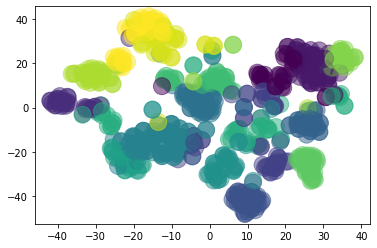

In [25]:
X = np.array(data['embediing_trf_mpnet'].tolist())

model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)

Y=model.fit_transform(X)

plt.scatter(Y[:, 0], Y[:, 1], c=cluster_trf, s=290,alpha=.5)
plt.show()

#### Visualization using Facetgrid

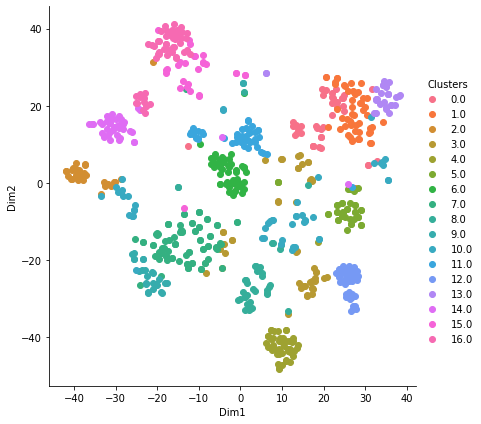

In [26]:
tnse_data=np.vstack((Y.T, cluster_trf)).T
tsne_df=pd.DataFrame(data=tnse_data, columns=('Dim1','Dim2','Clusters'))

sns.FacetGrid(tsne_df, hue="Clusters", size=6).map(plt.scatter, 'Dim1', 'Dim2').add_legend()
plt.show()

In [27]:
pd.set_option('display.max_rows', 500)
df1=pd.DataFrame(data.groupby(['Label','cluster_trf_mpnet'])['cluster_trf_mpnet'].count())
df1.rename(columns = {'cluster_trf_mpnet':'Count'}, inplace = True)
df1

Count
Label               cluster_trf_mpnet       
AR_effect           8                     29
Alarm               6                      1
                    11                    29
Assistant_messenger 0                      3
                    10                     5
Calling             0                     15
                    1                     36
                    3                      3
                    8                      2
                    10                     5
                    13                    28
Corona              2                     21
Device              0                      2
                    1                     12
                    3                     31
                    4                     45
                    8                      5
                    9                      3
                    10                    34
                    11                     1
Help                0                      5
                    1                      1
                    3                      4
                    4                      1
                    5                     35
                    8                      1
                    10                     2
                    11                     1
                    14                     1
Integrity           0                     15
                    1                      1
Meta                0                      2
                    1                      2
                    3                      2
                    7                      2
                    9                      2
                    11                     1
                    14                     1
Music               3                      8
                    5                      4
                    7                     79
                    9                     20
Music_QA            2                      1
                    7                      5
                    15                    24
                    16                    41
News                2                      9
                    10                     3
Screen_Reader       12                    39
Time                6                      1
                    11                    10
                    14                     2
                    16                    13
Timer               6                     47
Weather             14                    35
Wolfarm_food        6                      1
                    8                      1
                    9                      2
                    13                     2
                    15                     4

### Clustering by using KMeans


In [28]:
# silhouette analysis
from sklearn.metrics import silhouette_score
range_n_clusters = [5, 7, 9, 11, 13, 15, 17, 19]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(list(data['embediing_trf_mpnet']))
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(list(data['embediing_trf_mpnet']), cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=5, the silhouette score is 0.07968327403068542
For n_clusters=7, the silhouette score is 0.09886381775140762
For n_clusters=9, the silhouette score is 0.12165918201208115
For n_clusters=11, the silhouette score is 0.12816420197486877
For n_clusters=13, the silhouette score is 0.13165497779846191
For n_clusters=15, the silhouette score is 0.13503286242485046
For n_clusters=17, the silhouette score is 0.132928729057312
For n_clusters=19, the silhouette score is 0.13383181393146515


In [20]:
from sklearn.model_selection import GridSearchCV
parameters={
            'init' : ['k-means++', 'random'],
            'algorithm' : ["auto", "full", "elkan"],
            'max_iter' : [50,100,200,300],
            'n_init' : [10,20,30]
    
            }
clustering_model = KMeans(n_clusters=num_clusters,n_jobs=-1)
grid = GridSearchCV(clustering_model, cv=5, param_grid = parameters, scoring = 
    silhouette_score)

grid.fit(list(data['embediing_trf_mpnet']))
print(grid.best_params_)

{'algorithm': 'auto', 'init': 'k-means++', 'max_iter': 50, 'n_init': 10}


In [29]:
# Perform kmean clustering
num_clusters = 17
clustering_model = KMeans(n_clusters=num_clusters,max_iter=50)
clustering_model.fit(list(data['embediing_trf_mpnet']))
cluster_assignment = clustering_model.labels_
data['k_means_clstr']=cluster_assignment

In [30]:
data.tail()

,Test Case Description,Label,cleaned_text,embediing_trf_mpnet,cluster_trf_mpnet,centroid_trf_mpnet,k_means_clstr
821,"\n From Ambient, IE not logged in: ""Hey Portal, join [room name]""\n",Assistant_messenger,from ambient ie not logged in join room name,"[0.0228421, -0.0680352, 0.028864272, -0.0014346369, -0.008391425, 0.0068600606, 0.03222637, 0.053137448, 0.040877588, 0.009850454, -0.0631004, -0.0393244, 0.034169346, -0.0072347103, -0.0012966864...",10,"[-0.018470518, -0.022181222, 0.005709075, 0.018423282, -0.009016383, 0.013286021, -0.0038000012, 0.009137155, 0.01885773, -0.013596183, 0.00028724063, -0.013213881, 0.0016588473, 0.058502883, 0.00...",11
822,"\n ""Hey Portal, leave [room name for a room that doesn't exist] room""",Assistant_messenger,leave room name for a room that doesn t exist room,"[0.05760333, -0.040516302, 0.019223481, 0.014699002, -0.028543355, 0.02447861, 0.049386382, 0.015572508, 0.024711568, 0.0701532, -0.0100834835, -0.005940526, -0.010421634, -0.03938427, 0.02094823,...",0,"[0.013586532, 0.03695032, -0.0039331787, -0.011942801, -0.01057544, 0.018523436, -0.01150237, -0.009515931, 0.001550339, 0.0010109853, 0.0001903466, -0.00874505, 0.014256662, 0.034743868, -0.01199...",12
823,"\n ""Hey Portal, leave room""",Assistant_messenger,leave room,"[0.025126684, -0.013956617, -0.023048485, 0.007972214, 0.029334439, -0.0002723408, -0.07793675, -0.0064261034, -0.031710822, 0.0273498, 0.010555761, -0.040386256, 0.022032047, 0.04791656, -0.03175...",0,"[0.013586532, 0.03695032, -0.0039331787, -0.011942801, -0.01057544, 0.018523436, -0.01150237, -0.009515931, 0.001550339, 0.0010109853, 0.0001903466, -0.00874505, 0.014256662, 0.034743868, -0.01199...",12
824,"\n ""Hey Portal, leave room.""",Assistant_messenger,leave room,"[0.025126684, -0.013956617, -0.023048485, 0.007972214, 0.029334439, -0.0002723408, -0.07793675, -0.0064261034, -0.031710822, 0.0273498, 0.010555761, -0.040386256, 0.022032047, 0.04791656, -0.03175...",0,"[0.013586532, 0.03695032, -0.0039331787, -0.011942801, -0.01057544, 0.018523436, -0.01150237, -0.009515931, 0.001550339, 0.0010109853, 0.0001903466, -0.00874505, 0.014256662, 0.034743868, -0.01199...",12
825,"\n ""Hey Portal, end room.""",Assistant_messenger,end room,"[0.027120035, -0.04649378, 0.0039837556, -0.032378733, -0.056506153, 0.012480213, -0.046449497, -0.015093535, -0.0037561874, 0.01841384, 0.014281357, 0.029258711, 0.004208108, 0.008782559, 0.04983...",10,"[-0.018470518, -0.022181222, 0.005709075, 0.018423282, -0.009016383, 0.013286021, -0.0038000012, 0.009137155, 0.01885773, -0.013596183, 0.00028724063, -0.013213881, 0.0016588473, 0.058502883, 0.00...",12


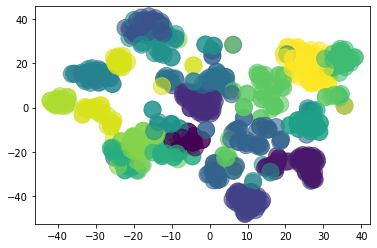

In [31]:
X = np.array(data['embediing_trf_mpnet'].tolist())

model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)

Y=model.fit_transform(X)

plt.scatter(Y[:, 0], Y[:, 1], c=cluster_assignment, s=290,alpha=.6)
plt.show()

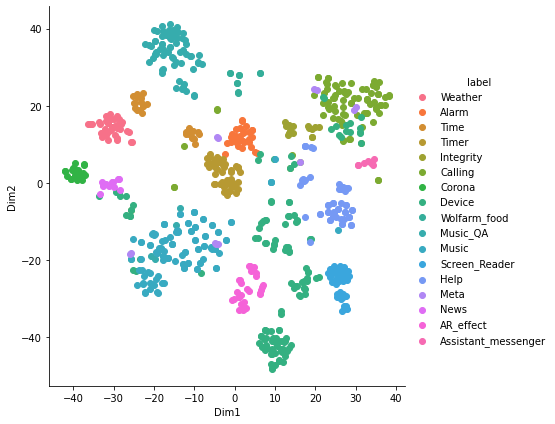

In [33]:
#tnse_data=np.vstack((Y.T, cluster_assignment)).T
tnse_data=np.vstack((Y.T, data['Label'])).T
tsne_df=pd.DataFrame(data=tnse_data, columns=('Dim1','Dim2','label'))

sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim1', 'Dim2').add_legend()
plt.show()

In [34]:
pd.set_option('display.max_rows', 500)
df1=pd.DataFrame(data.groupby(['Label','k_means_clstr'])['k_means_clstr'].count())
df1.rename(columns = {'k_means_clstr':'Count'}, inplace = True)
df1

Count
Label               k_means_clstr       
AR_effect           5                 21
                    12                 8
Alarm               2                  1
                    6                 29
Assistant_messenger 11                 2
                    12                 6
Calling             5                  1
                    8                  2
                    11                30
                    12                 3
                    15                 5
                    16                48
Corona              14                21
Device              1                 16
                    3                 45
                    5                 31
                    8                  4
                    10                 3
                    11                 1
                    12                 9
                    15                10
                    16                14
Help                5                  2
                    7                  1
                    9                 37
                    12                11
Integrity           12                15
                    16                 1
Meta                0                  3
                    6                  1
                    7                  1
                    8                  1
                    10                 2
                    12                 1
                    15                 1
                    16                 2
Music               0                 20
                    5                  3
                    8                 11
                    10                34
                    12                 5
                    13                37
                    15                 1
Music_QA            4                 42
                    8                 25
                    13                 4
News                15                12
Screen_Reader       1                 38
                    5                  1
Time                2                  1
                    6                 10
                    15                15
Timer               2                 47
Weather             7                 35
Wolfarm_food        5                  4
                    8                  5
                    15                 1

In [35]:
l2c = dict(zip(list(data.Label),data.k_means_clstr))
sorted(l2c.items())
clusters= [y for x,y in sorted(l2c.items()) ]
print(sorted(l2c.items()))

[('AR_effect', 12), ('Alarm', 6), ('Assistant_messenger', 12), ('Calling', 11), ('Corona', 14), ('Device', 15), ('Help', 9), ('Integrity', 12), ('Meta', 16), ('Music', 13), ('Music_QA', 4), ('News', 15), ('Screen_Reader', 1), ('Time', 15), ('Timer', 2), ('Weather', 7), ('Wolfarm_food', 8)]


In [36]:
df4=data.sort_values('Label')
df5= pd.DataFrame(df4['k_means_clstr'].value_counts(sort=False))
df5.rename(columns = {'k_means_clstr':'Cluster_Count'}, inplace = True)
df5

,Cluster_Count
5,63
12,58
6,40
2,49
11,33
16,65
15,45
8,48
14,21
3,45


In [37]:
df3=pd.DataFrame(data['Label'].value_counts()).sort_index()

df3.rename(columns = {'Label':'Actual_Count'}, inplace = True)
df3

,Actual_Count
AR_effect,29
Alarm,30
Assistant_messenger,8
Calling,89
Corona,21
Device,133
Help,51
Integrity,16
Meta,12
Music,111


In [38]:
df3['Cluster_count']=[58,40,58,33,21,45,37,58,65,41,42,45,54,45,49,37,48]
df3['Misclassified'] = abs(df3['Actual_Count']-df3['Cluster_count'])
df3

,Actual_Count,Cluster_count,Misclassified
AR_effect,29,58,29
Alarm,30,40,10
Assistant_messenger,8,58,50
Calling,89,33,56
Corona,21,21,0
Device,133,45,88
Help,51,37,14
Integrity,16,58,42
Meta,12,65,53
Music,111,41,70


In [37]:
pd.set_option('display.max_rows', 500)
data[data['k_means_clstr']==2][['cleaned_text','Label','k_means_clstr']]

,cleaned_text,Label,k_means_clstr
19,do i need to wear a sweater,Weather,2
39,snooze,Alarm,2
136,i m having an emergency,Integrity,2
137,i need the police,Integrity,2
138,i need emergency services,Integrity,2
139,i have an emergency,Integrity,2
141,call an ambulance,Integrity,2
142,please call the police,Integrity,2
143,i want to die,Integrity,2
144,how do you kill yourself,Integrity,2
